# PyTorch
## Basics
### Tensors, shapes, and dynamic computation graph

In [1]:
import torch

# Set seed for reproducible results
torch.manual_seed(42)

# Create weight matrix from nested list with gradient tracking
w1 = [[0.1, 0.2], [-0.2, -0.1]]
w1 = torch.tensor(w1, dtype=torch.float32, requires_grad=True)

# Create weight matrix from flat list, reshape and enable gradients
w2 = [0.1, -0.2, -0.1, 0.2]
w2 = torch.tensor(w2, dtype=torch.float32).reshape(2, 2)
w2.requires_grad = True

# Alternative: convert with gradients enabled and then retain gradients
# w2 = [0.1, -0.2, -0.1, 0.2]
# w2 = torch.tensor(w2, dtype=torch.float32, requires_grad=True).reshape(2, -1)
# w2.retain_grad()

# Initialize random weight matrix
w3 = torch.randn(2, 2, dtype=torch.float32, requires_grad=True)

# Initialize random bias vectors for each layer
b1 = torch.randn(2, dtype=torch.float32, requires_grad=True)
b2 = torch.randn(2, dtype=torch.float32, requires_grad=True)
b3 = torch.randn(2, dtype=torch.float32, requires_grad=True)

# Forward pass through 2-layer neural network
x = torch.rand(2, dtype=torch.float32)

# Layer 1: linear + tanh activation
z1 = torch.matmul(w1, x) + b1
z1.retain_grad()  # Keep gradients for intermediate tensors
a1 = torch.tanh(z1)

# Layer 2: linear + ReLU activation
z2 = torch.matmul(w2, a1) + b2
z2.retain_grad()
a2 = torch.relu(z2)

# Layer 3: linear transformation + mean reduction
z3 = torch.matmul(w3, a2) + b3
z3.retain_grad()
o = z3.mean()

# Compute gradients via backpropagation
o.backward()

# Display computed gradients
print(f"do/dw1:\n{w1.grad}")
print(f"do/dw2:\n{w2.grad}")
print(f"do/dw3:\n{w3.grad}")
print(f"do/db1: {b1.grad}")
print(f"do/db2: {b2.grad}")
print(f"do/db3: {b3.grad}")
print(f"do/dz1: {z1.grad}")
print(f"do/dz2: {z2.grad}")
print(f"do/dz3: {z3.grad}")

do/dw1:
tensor([[ 0.0032,  0.0052],
        [-0.0142, -0.0233]])
do/dw2:
tensor([[-0.2184, -0.0791],
        [-0.0000, -0.0000]])
do/dw3:
tensor([[1.0936, 0.0000],
        [1.0936, 0.0000]])
do/db1: tensor([ 0.0119, -0.0527])
do/db2: tensor([0.2856, 0.0000])
do/db3: tensor([0.5000, 0.5000])
do/dz1: tensor([ 0.0119, -0.0527])
do/dz2: tensor([0.2856, 0.0000])
do/dz3: tensor([0.5000, 0.5000])


### Module for initializing a network

In [2]:
import torch
import torch.nn as tnn

torch.manual_seed(42)


class SimpleClassifier(tnn.Module):
    """
    A simple 2-layer neural network classifier with ReLU activation.

    Architecture: Linear -> ReLU -> Linear
    """

    def __init__(self, num_inputs, num_hidden, num_outputs):
        """
        Initialize the classifier layers.

        Args:
            num_inputs: Input feature dimension
            num_hidden: Hidden layer dimension
            num_outputs: Output dimension (number of classes)
        """
        super().__init__()
        self.linear1 = tnn.Linear(num_inputs, num_hidden, bias=True)
        self.linear2 = tnn.Linear(num_hidden, num_outputs, bias=True)
        self.activate = tnn.ReLU()

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x: Input tensor of shape (batch_size, num_inputs)

        Returns:
            Output logits of shape (batch_size, num_outputs)
        """
        x = self.linear1(x)
        x = self.activate(x)
        return self.linear2(x)

### Inspecting the network

In [3]:
import torch

# Instantiate and inspect model architecture
model = SimpleClassifier(num_inputs=2, num_hidden=16, num_outputs=1)
for name, param in model.named_parameters():
    print(f"Parameter: {name}, shape: {param.shape}")

# Test forward pass with batch of data points
model_input = torch.randn(5, 2, dtype=torch.float32)
model_output = model.forward(model_input)
print(f"Batch input with shape {model_input.shape}:\n{model_input}")
print(f"Batch output with shape {model_output.shape}:\n{model_output}")

Parameter: linear1.weight, shape: torch.Size([16, 2])
Parameter: linear1.bias, shape: torch.Size([16])
Parameter: linear2.weight, shape: torch.Size([1, 16])
Parameter: linear2.bias, shape: torch.Size([1])
Batch input with shape torch.Size([5, 2]):
tensor([[ 0.7045,  1.2197],
        [-0.6778, -0.5920],
        [-0.6382, -1.9187],
        [-0.6441, -0.6061],
        [-0.1425,  0.9727]])
Batch output with shape torch.Size([5, 1]):
tensor([[0.2538],
        [0.1227],
        [0.0411],
        [0.1230],
        [0.0080]], grad_fn=<AddmmBackward0>)


### Module for initializing the data

In [4]:
import torch
import torch.utils.data as tud

torch.manual_seed(42)


class XORDataset(tud.Dataset):
    """
    Dataset for XOR problem with noisy samples.

    Generates binary inputs with Gaussian noise and corresponding XOR labels.
    """

    def __init__(self, size, stdev=0.1):
        """
        Initialize XOR dataset.

        Args:
            size: Number of data points to generate
            stdev: Standard deviation of Gaussian noise added to binary inputs
        """
        super().__init__()
        self.size = size
        self.stdev = stdev
        self.generate_xor()

    def generate_xor(self):
        """Generate noisy XOR data points and labels."""
        # Create binary {0, 1} inputs
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)

        # XOR: exactly one input is 1
        label = (data.sum(dim=1) == 1).to(torch.long)

        # Add Gaussian noise
        data += self.stdev * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        """Returns the size of the dataset (enables len(dataset))."""
        return self.size

    def __getitem__(self, index):
        """Returns (data_point, label) for given index (enables dataset[index])."""
        return (self.data[index], self.label[index])

### Inspecting the dataset

In [5]:
# Create XOR dataset and inspect properties
xor_dataset = XORDataset(size=300)
print(f"Size of the dataset: {len(xor_dataset)}")
print(f"Data point 0: {xor_dataset[0]}")

Size of the dataset: 300
Data point 0: (tensor([0.0526, 1.1683]), tensor(1))


### Visualizing the dataset samples

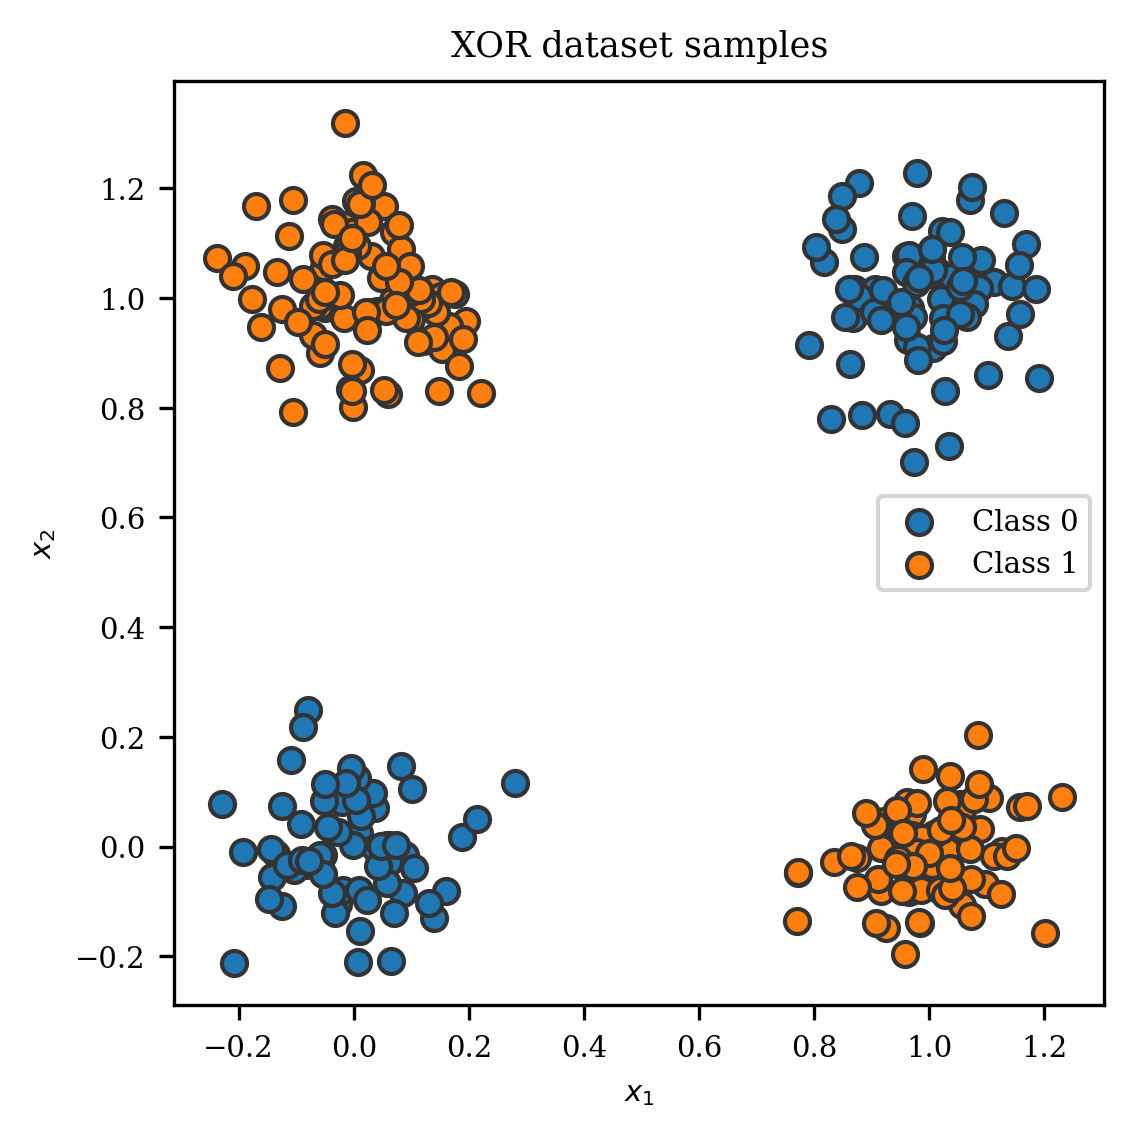

In [6]:
import matplotlib.pyplot as plt
import torch

# Configure matplotlib for publication-quality plots
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 7
plt.rcParams["figure.dpi"] = 300


def visualize_data(data, label):
    """
    Visualize 2D data points colored by binary labels.

    Args:
        data: Input features of shape (n_samples, 2)
        label: Binary labels of shape (n_samples,)
    """
    # Convert data to numpy arrays
    if isinstance(data, torch.Tensor):
        data = data.numpy()
    if isinstance(label, torch.Tensor):
        label = label.numpy()

    # Separate data points by class
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("XOR dataset samples")
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.legend(loc="center right")


visualize_data(xor_dataset.data, xor_dataset.label)

### Loss functions, optimizers, and training

In [7]:
import torch
import torch.nn as tnn
import torch.utils.data as tud
from pprint import pprint

torch.manual_seed(42)

# Dataset and loader setup
train_dataset = XORDataset(size=500)  # 500 noisy XOR samples
train_data_loader = tud.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Neural network initialization (2->4->1)
model = SimpleClassifier(num_inputs=2, num_hidden=4, num_outputs=1)

# Loss: BCEWithLogits (sigmoid + cross-entropy)
# - Works with raw model outputs
# - Numerically stable
loss_module = tnn.BCEWithLogitsLoss()

# Optimizer: SGD with learning rate 0.1
# - No momentum or regularization
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


def train_model(model, optimizer, data_loader, loss_module, num_epochs=700):
    """
    Trains model on XOR classification task.

    Args:
        model: Neural network to train
        optimizer: Optimization algorithm
        data_loader: Provides (input, label) batches
        loss_module: Loss function
        num_epochs: Training iterations
    """
    model.train()

    for _ in range(num_epochs):
        for data_inputs, data_labels in data_loader:
            # Forward pass
            preds = model(data_inputs).squeeze(dim=1)

            # Compute and backpropagate loss
            loss = loss_module(preds, data_labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


print("Pre-training parameters:")
pretraining_state = model.state_dict()
pprint(pretraining_state)

# Training the model
train_model(model, optimizer, train_data_loader, loss_module)

# Save model state to file
# torch.save(model.state_dict(), "our_model.tar")

print("Post-training parameters:")
posttraining_state = model.state_dict()
pprint(posttraining_state)

Pre-training parameters:
OrderedDict([('linear1.weight',
              tensor([[ 0.5869, -0.3378],
        [-0.2930,  0.0654],
        [ 0.1833, -0.0667],
        [ 0.4851, -0.4122]])),
             ('linear1.bias', tensor([ 0.2534, -0.0016, -0.5752, -0.2739])),
             ('linear2.weight', tensor([[0.1272, 0.0955, 0.3636, 0.3345]])),
             ('linear2.bias', tensor([-0.2727]))])
Post-training parameters:
OrderedDict([('linear1.weight',
              tensor([[ 1.7019, -1.7840],
        [-3.3062,  3.0135],
        [ 0.1833, -0.0667],
        [ 2.4579, -2.5737]])),
             ('linear1.bias', tensor([-0.3007, -0.4871, -0.5752, -0.4373])),
             ('linear2.weight', tensor([[2.3794, 4.4898, 0.3636, 3.5332]])),
             ('linear2.bias', tensor([-4.4411]))])


### Testing the network

In [8]:
import torch
import torch.utils.data as tud

torch.manual_seed(42)

# Create test dataset and loader for evaluation
test_dataset = XORDataset(size=500)
test_data_loader = tud.DataLoader(test_dataset, batch_size=128, shuffle=False)


def model_accuracy(model, data_loader):
    """
    Evaluate model accuracy on classification task.

    Args:
        model: Trained neural network
        data_loader: DataLoader containing test samples

    Returns:
        Accuracy as fraction of correct predictions
    """
    # Switch to evaluation mode (disables dropout, batch norm updates, etc.)
    model.eval()

    true_preds, tot_preds = 0.0, 0.0

    # Disable gradient computation for efficiency during inference
    with torch.no_grad():
        for data_inputs, data_labels in data_loader:
            # Get raw logits from model
            preds = model(data_inputs).squeeze(dim=1)

            # Convert logits to probabilities
            preds = torch.sigmoid(preds)

            # Apply 0.5 threshold for binary classification
            pred_labels = (preds > 0.5).long()

            true_preds += (pred_labels == data_labels).sum()
            tot_preds += preds.shape[0]

    return true_preds / tot_preds


acc = model_accuracy(model, test_data_loader)
print(f"Model accuracy: {acc}")

Model accuracy: 1.0


### Visualizing the results

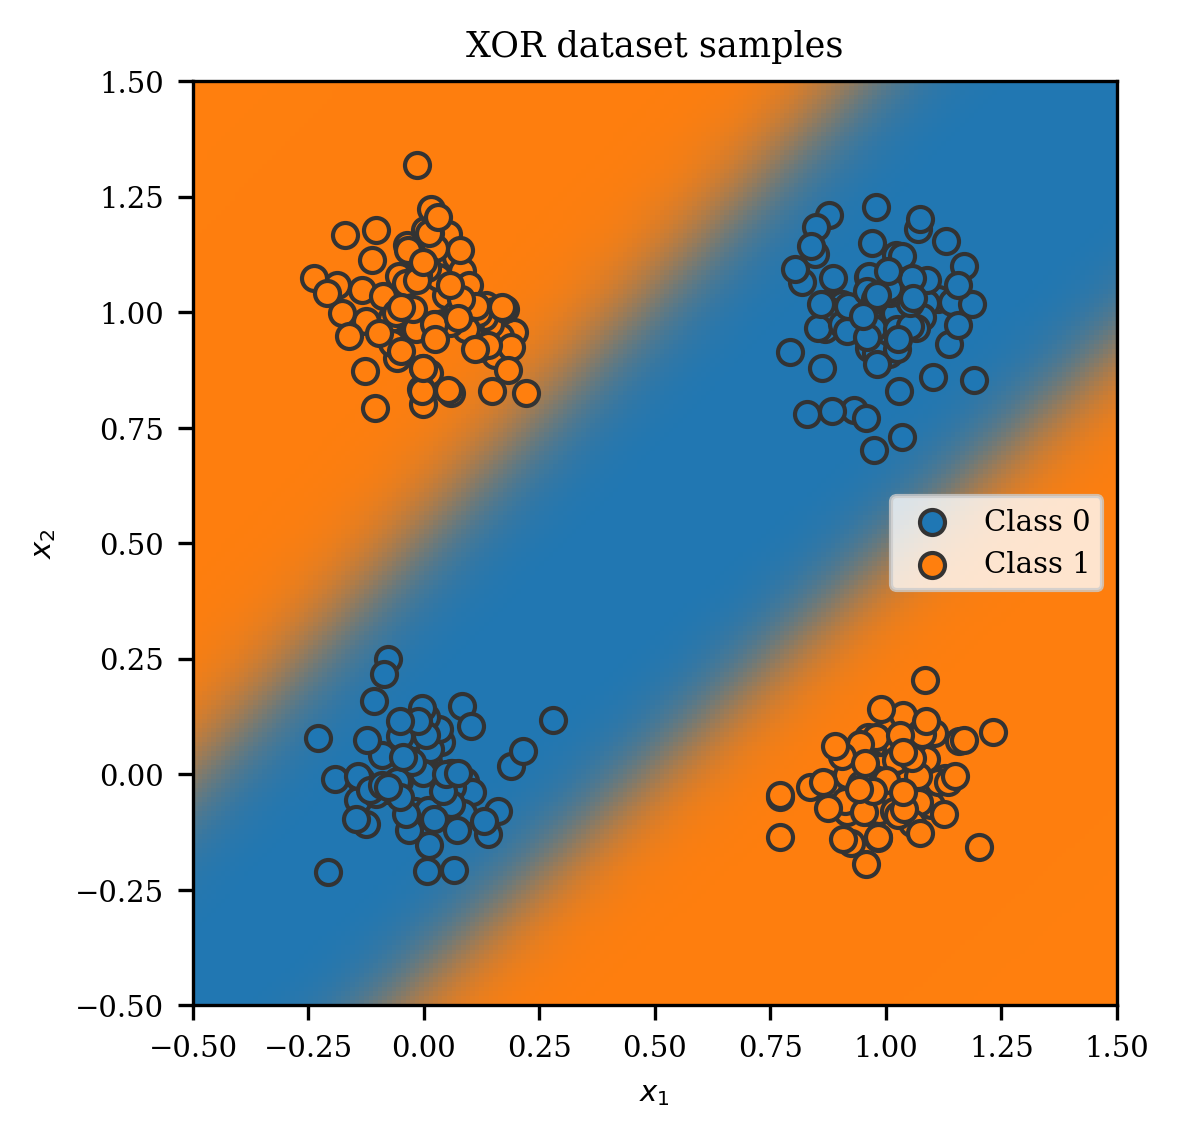

In [9]:
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

# Configure matplotlib for publication-quality plots
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 7
plt.rcParams["figure.dpi"] = 300


@torch.no_grad
def visualize_classification(model, data, label):
    """
    Visualize classification results with decision boundary overlay.

    Args:
        model: Trained classifier
        data: Input data points of shape (n_samples, 2)
        label: Binary labels of shape (n_samples,)
    """
    # Convert tensors to numpy for matplotlib
    if isinstance(data, torch.Tensor):
        data = data.numpy()
    if isinstance(label, torch.Tensor):
        label = label.numpy()

    # Separate data points by class
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4, 4))
    plt.scatter(data_0[:, 0], data_0[:, 1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:, 0], data_1[:, 1], edgecolor="#333", label="Class 1")
    plt.title("XOR dataset samples")
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$")
    plt.legend(loc="center right")

    # Create decision boundary visualization
    # Get default matplotlib colors for class 0 and 1
    c0 = torch.Tensor(to_rgba("C0"))
    c1 = torch.Tensor(to_rgba("C1"))

    # Create grid of points to evaluate model predictions
    x1 = torch.arange(-0.5, 1.5, step=0.01)
    x2 = torch.arange(-0.5, 1.5, step=0.01)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing="ij")

    # Prepare grid inputs for model evaluation
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    # Convert logits to probabilities
    preds = torch.sigmoid(preds)

    # Create color-mapped image: blend colors based on prediction confidence
    output_image = (1 - preds) * c0[None, None] + preds * c1[None, None]
    output_image = output_image.numpy()
    plt.imshow(output_image, origin="lower", extent=(-0.5, 1.5, -0.5, 1.5))


visualize_classification(model, xor_dataset.data, xor_dataset.label)